# Avacado Project
### <u>Problem Statement</u>:

<div style="text-align: justify">
Avocado is a fruit consumed by people heavily in the United States. 
Content. This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. 

Starting in 2013, the table below reflects an expanded, multi-outlet retail data set.Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. 

The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.
</div>

Some relevant columns in the dataset:

Date - The date of the observation
   * AveragePrice - the average price of a single avocado
   * type - conventional or organic
   * year - the year
   * Region - the city or region of the observation
   * Total Volume - Total number of avocados sold
   * 4046 - Total number of avocados with PLU 4046 sold
   * 4225 - Total number of avocados with PLU 4225 sold
   * 4770 - Total number of avocados with PLU 4770 sold

In [1]:
# 1. Import the libraries
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical libraries
import phik
from scipy.stats import pearsonr
from scipy.stats import zscore

from pandas.api.types import is_numeric_dtype

# feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('avocado.csv')

In [3]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [5]:
# checking for null values
df.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

<font color = red>
The data has three columns as string entries however the date should be changed to date type. Aslo there aren't any null values. Also the first column, being a custom index is dropped
</font>

In [6]:
df.drop(df.columns[0], axis =1, inplace = True)

also the date column is dropped as it would be redundant since the 'Year' column is already present

In [7]:
df.drop(df.columns[0], axis = 1, inplace = True)

In [8]:
# checking the statistics of the numerical data
df.describe().round()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.0,18249.0,18249.0,18249.0,18249.0,18249.0,18249.0,18249.0,18249.0,18249.0
mean,1.0,850644.0,293008.0,295155.0,22840.0,239639.0,182195.0,54338.0,3106.0,2016.0
std,0.0,3453545.0,1264989.0,1204120.0,107464.0,986242.0,746179.0,243966.0,17693.0,1.0
min,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0
25%,1.0,10839.0,854.0,3009.0,0.0,5089.0,2849.0,127.0,0.0,2015.0
50%,1.0,107377.0,8645.0,29061.0,185.0,39744.0,26363.0,2648.0,0.0,2016.0
75%,2.0,432962.0,111020.0,150207.0,6243.0,110783.0,83338.0,22029.0,132.0,2017.0
max,3.0,62505647.0,22743616.0,20470573.0,2546439.0,19373134.0,13384587.0,5719097.0,551694.0,2018.0


In [9]:
# Now we check for variance thresholding
low_variance = []
high_variance= []
for col in df.columns:
    val = df[col].unique().shape[0]/len(df)*100
    print(f'{val:0.3f}')
    if val < 1:
        low_variance.append(col)
    elif val > 99:
        high_variance.append(col)

1.419
99.934
97.003
99.200
66.146
99.167
94.915
82.646
30.621
0.011
0.022
0.296


In [10]:
low_variance

['type', 'year', 'region']

In [11]:
high_variance

['Total Volume', '4225', 'Total Bags']

The 'type', 'year', 'region', 'Average Price' though have a very low variance they are categorical and hence should not be dropped. <br>
The 'Total Volume' apparently has 99% variance, it also the summation of the of the other 3 columns '4046', '4025' and '4770', because of its high variability and redundancy it is dropped from the dataset, similarly the 'total bags' will be dropped for the same reasons

In [12]:
df.drop(columns = ['Total Volume', 'Total Bags'], inplace = True)

In [13]:
df.shape

(18249, 10)

In [14]:
# Checking for the remaining columns
df.head()

,AveragePrice,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,type,year,region
0,1.33,1036.74,54454.85,48.16,8603.62,93.25,0.0,conventional,2015,Albany
1,1.35,674.28,44638.81,58.33,9408.07,97.49,0.0,conventional,2015,Albany
2,0.93,794.70,109149.67,130.50,8042.21,103.14,0.0,conventional,2015,Albany
3,1.08,1132.00,71976.41,72.58,5677.40,133.76,0.0,conventional,2015,Albany
4,1.28,941.48,43838.39,75.78,5986.26,197.69,0.0,conventional,2015,Albany


# Part 1: Regression Problem Average Price Prediction

In [15]:
# Firstly we assume the 'year' is a categorical feature and convert it to type 'object'
df['year'] = df['year'].astype('object')

In [16]:
# Finding the correlation between the average price and the other numerical features
temp = pd.DataFrame()
score = []
pvalue = []
feature = []

for col in df.columns[1:]:
    if(is_numeric_dtype(df[col])):
        score.append(pearsonr(df[col], df['AveragePrice'])[0])
        pvalue.append(pearsonr(df[col], df['AveragePrice'])[1])
        feature.append(col)
temp['feature'] = feature
temp['score'] = score
temp['pvalue']= pvalue

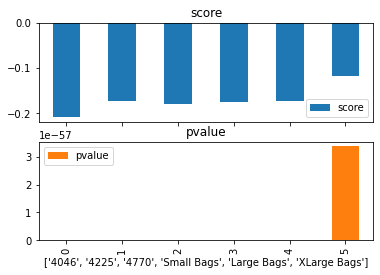

In [17]:
temp.plot.bar(subplots = True)
plt.xlabel(feature)
plt.show()

all features negatively correlate with the target variable and this would make sense, since with the increase of the volume of the sales the average price gets driven down

In [18]:
# checking the correlation with the categorical values and numerical values using phik

In [19]:
temp = pd.DataFrame()
score = []
pvalue = []
feature = []

for col in df.columns[1:]:
    if is_numeric_dtype(df[col]):
        score.append(phik.phik_from_array(df[col], df['AveragePrice'], [col]))
        pvalue.append(phik.significance.significance_from_array(df[col], df['AveragePrice'], [col])[0])
        feature.append(col)
    else:
        score.append(phik.phik_from_array(df[col], df['AveragePrice']))
        pvalue.append(phik.significance.significance_from_array(df[col], df['AveragePrice'])[0])
        feature.append(col)

In [20]:
temp['feature'] = feature
temp['score'] = score
temp['pvalue']= pvalue

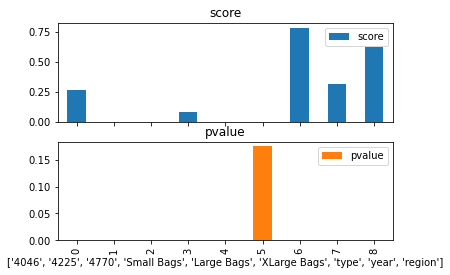

In [21]:
temp.plot.bar(subplots = True)
plt.xlabel(feature)
plt.show()

<font color = red>
'XLarge Bags' apparently has a very poor correlation with the target variable 'AveragePrice', next we will check if it shares a correlation with other features and whether it can be dropped
</font>

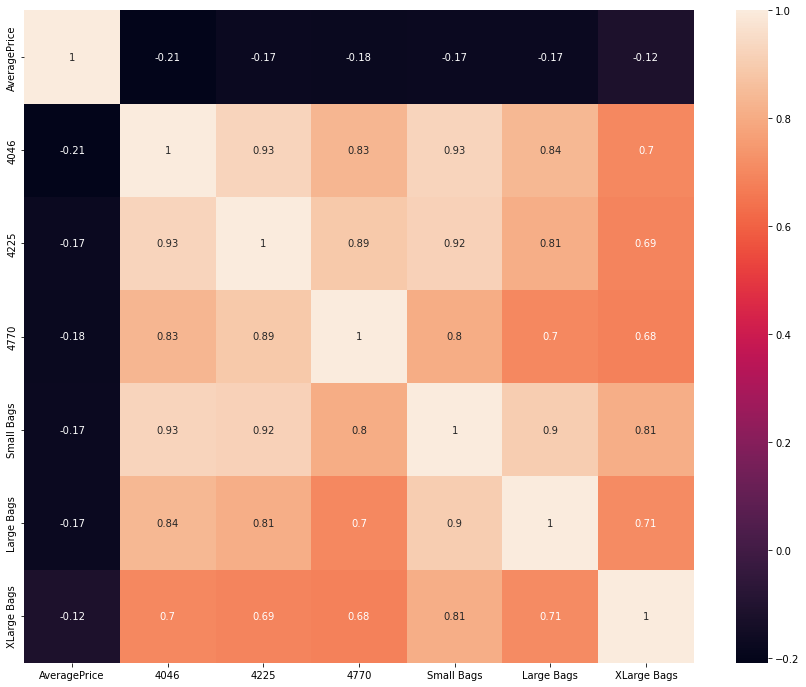

In [22]:
# Checking for multicollinearity between the features
plt.figure(figsize = (15, 12))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [24]:
temp = pd.DataFrame()
temp['Feature'] = df.iloc[:,1:7].columns
temp['VIF Score'] = [vif(df.iloc[:,1:7], i) for i in range(6)]

In [25]:
temp.sort_values('VIF Score', ascending = False)

,Feature,VIF Score
3,Small Bags,20.457434
1,4225,14.060881
0,4046,10.435894
4,Large Bags,5.804713
2,4770,5.585092
5,XLarge Bags,3.505955


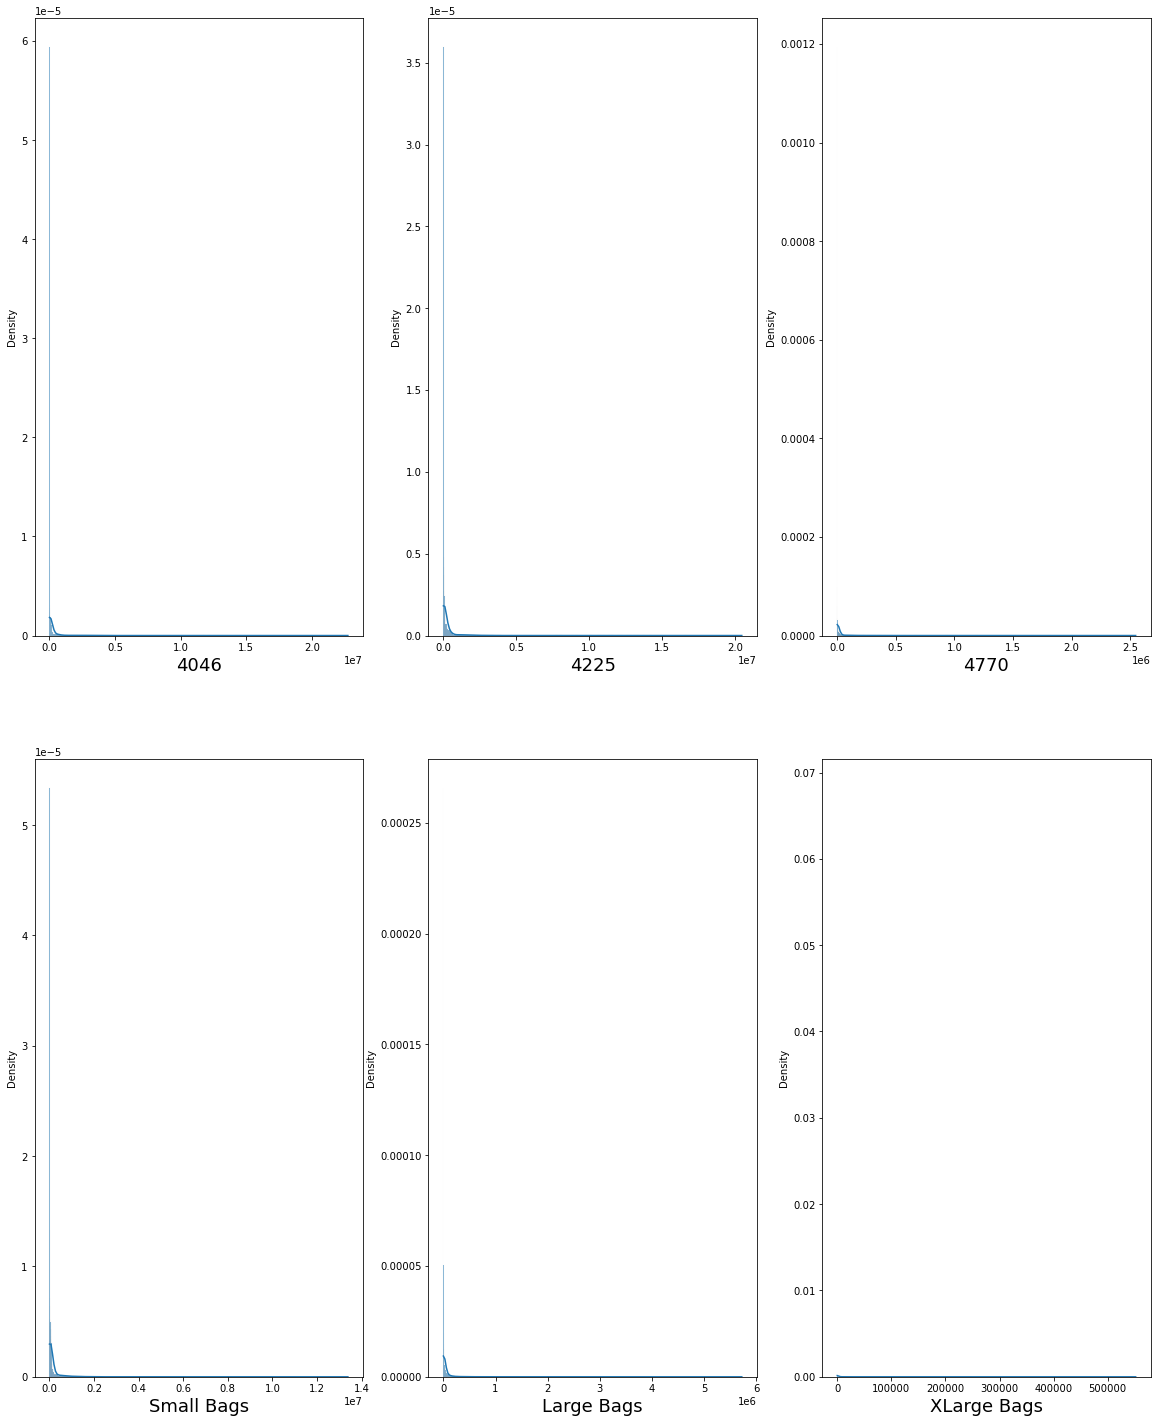

In [33]:
# Plotting a histogram to view the distribution of data in each numerical feature
plt.figure(figsize = (20,25))
plotnumber = 1

for col in df.columns[1:]:
     if is_numeric_dtype(df[col]):
        if plotnumber < 7:
            plt.subplot(2,3,plotnumber)
            sns.histplot(df[col], kde = True, stat = 'density')
            plt.xlabel(col, fontsize = 18)
        plotnumber += 1
plt.show()

In [37]:
from sklearn.preprocessing import PowerTransformer

In [41]:
from pandas.api import get_numeric_

ImportError: cannot import name 'get_numeric_' from 'pandas.api' (C:\Users\zobekenobe\anaconda3\envs\datasci\lib\site-packages\pandas\api\__init__.py)

In [43]:
numerical_features = [col for col in df.columns[1:] if is_numeric_dtype(df[col])]

In [47]:
temp = pd.DataFrame(PowerTransformer().fit_transform(df[numerical_features]))

In [48]:
temp

,0,1,2,3,4,5
0,-0.658619,0.307313,-0.247250,-0.340627,-0.773351,-0.699849
1,-0.776870,0.231647,-0.201041,-0.306425,-0.763435,-0.699849
2,-0.731947,0.579503,-0.007072,-0.366303,-0.750820,-0.699849
3,-0.634200,0.415100,-0.148322,-0.496853,-0.691865,-0.699849
4,-0.685293,0.224806,-0.137918,-0.477201,-0.600975,-0.699849
...,...,...,...,...,...,...
18244,-0.467366,-0.919470,-1.238310,-0.178839,-0.410859,-0.699849
18245,-0.619883,-0.665372,-1.238310,-0.325977,-0.481465,-0.699849
18246,-0.619831,-0.772496,0.401546,-0.308728,-0.943486,-0.699849
18247,-0.550282,-0.710543,0.401246,-0.248932,-0.908510,-0.699849


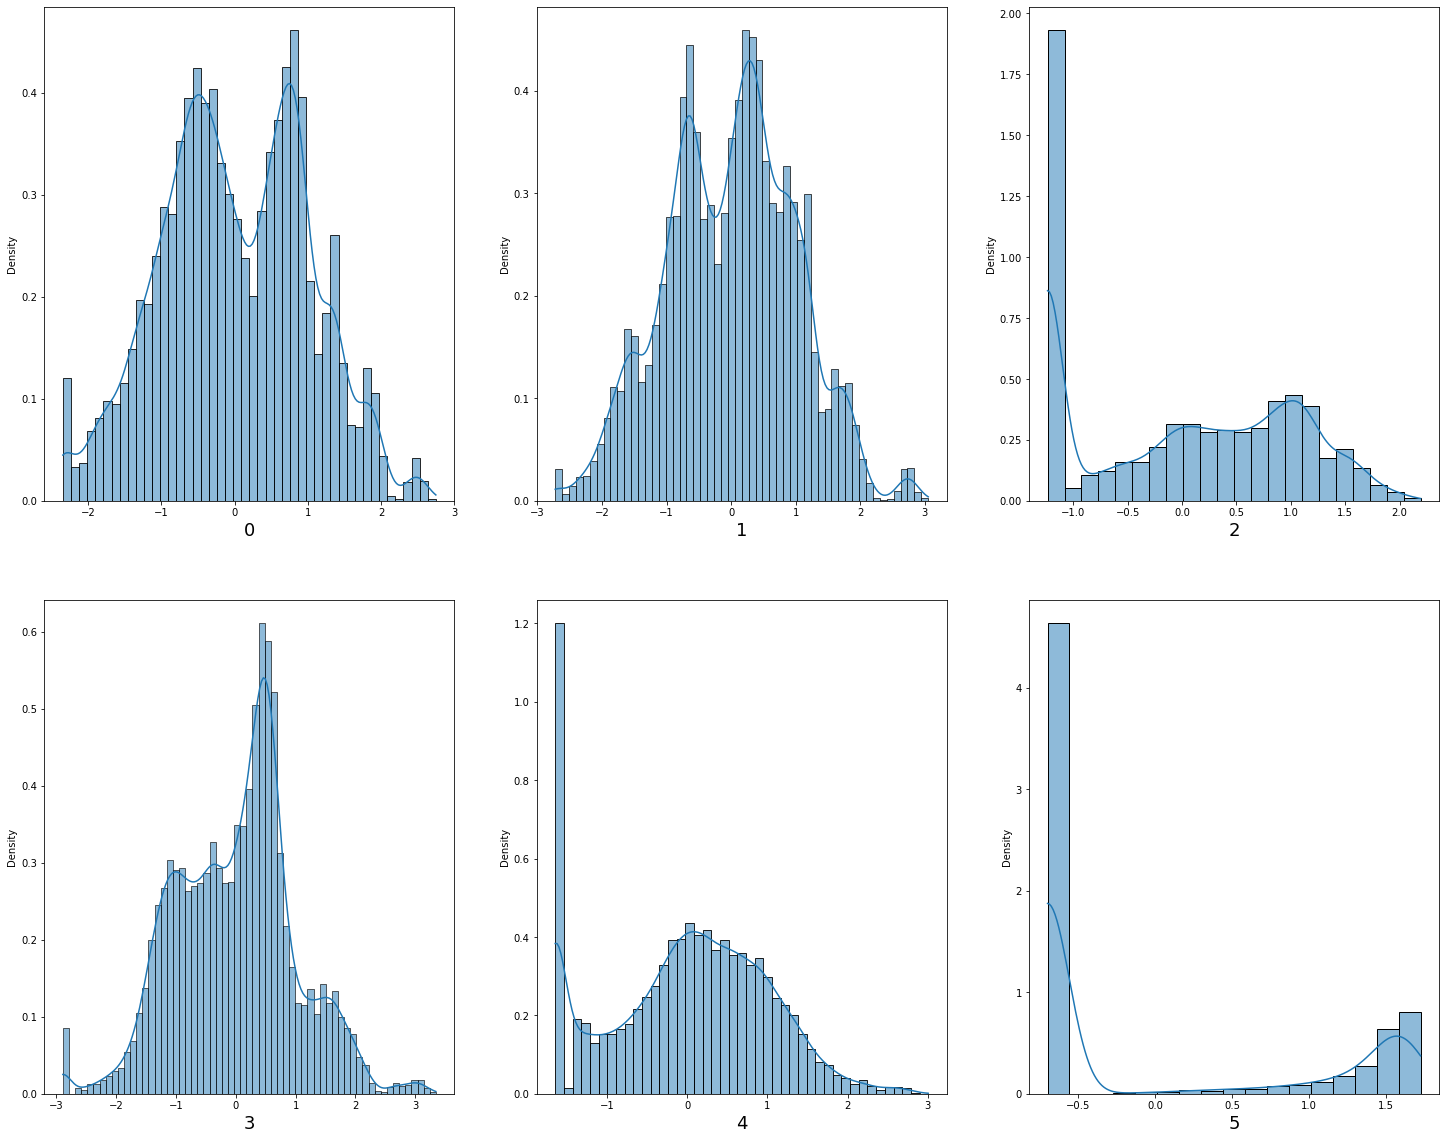

In [57]:
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in range(len(numerical_features)):
    plt.subplot(2,3,plotnumber)
    sns.histplot(temp[col], kde = True, stat = 'density')
    plt.xlabel(col, fontsize = 18)
    plotnumber += 1
plt.show()

The data looks much better now, however there is still some skewness in features 2,4 and 5

In [58]:
temp.skew()

0   -0.022679
1   -0.017740
2    0.032184
3    0.007058
4   -0.073809
5    0.793520
dtype: float64

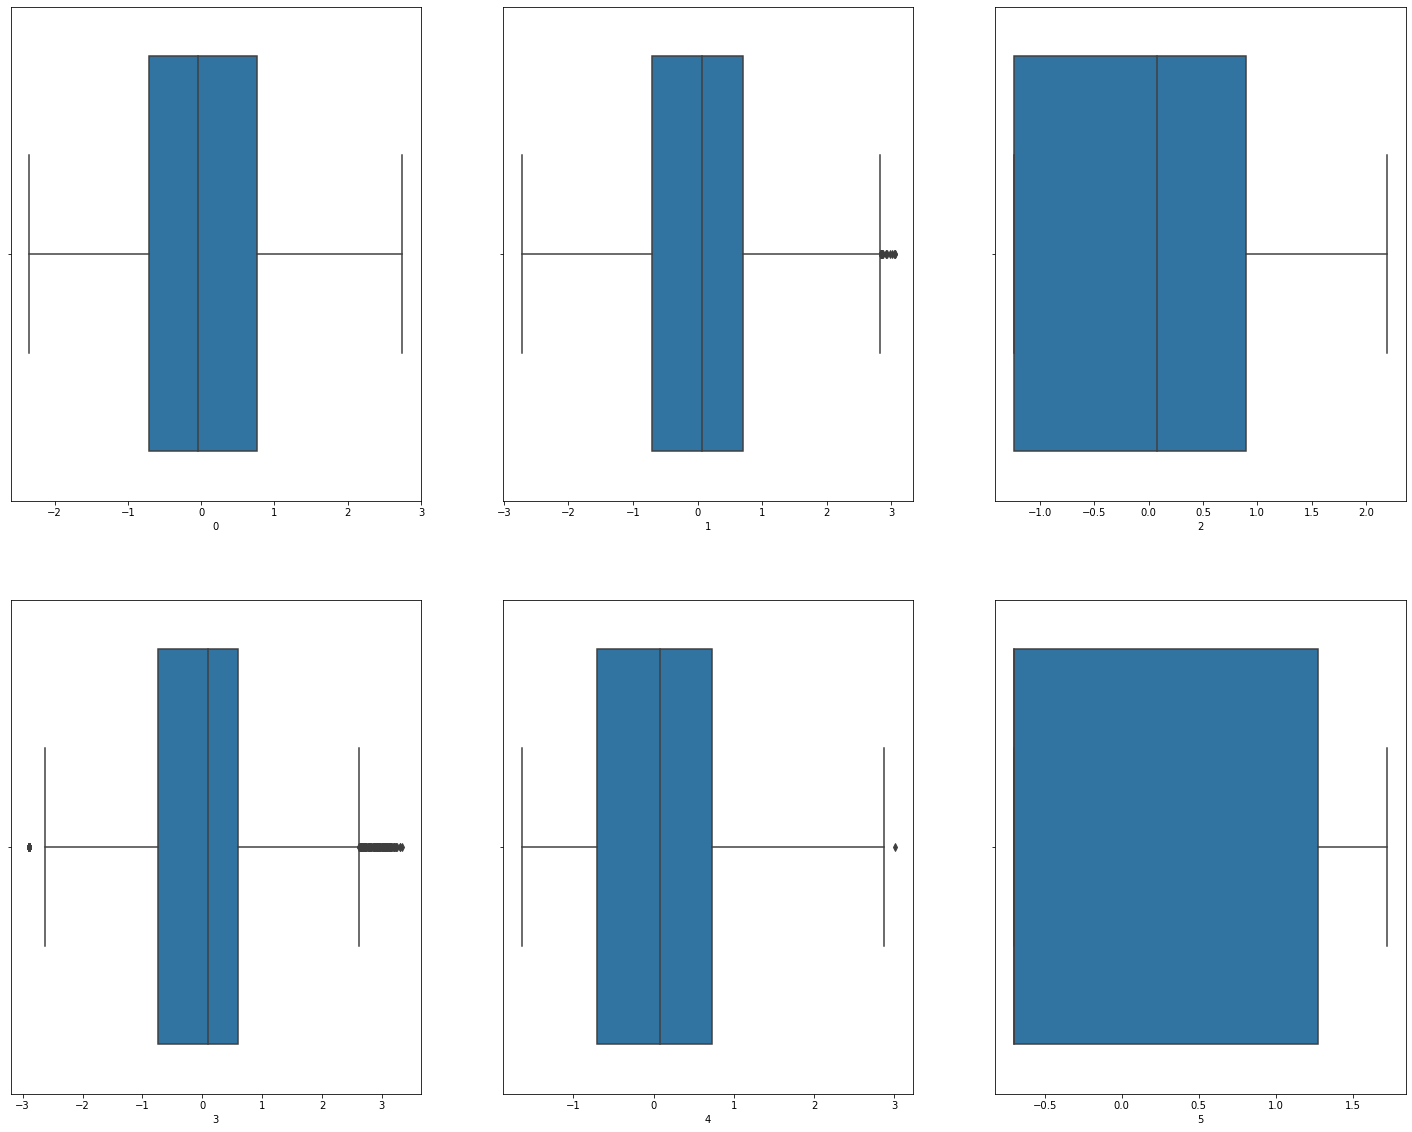

In [65]:
# we can check for outliers in the features with numerical datatypes
plt.figure(figsize = (25, 20))
plotnumber = 1
for col in temp.columns:
    if plotnumber < 7:
        plt.subplot(2,3,plotnumber)
        sns.boxplot(temp[col], orient = 'h')
    plotnumber += 1
plt.show()

 after performing a power transform and visualizing the via boxplots the data looks like doesn't 
 have many outlier points

In [81]:
df.loc[:, numerical_features] = temp.values

In [82]:
df

,AveragePrice,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,type,year,region
0,1.33,-0.658619,0.307313,-0.247250,-0.340627,-0.773351,0.0,conventional,2015,Albany
1,1.35,-0.776870,0.231647,-0.201041,-0.306425,-0.763435,0.0,conventional,2015,Albany
2,0.93,-0.731947,0.579503,-0.007072,-0.366303,-0.750820,0.0,conventional,2015,Albany
3,1.08,-0.634200,0.415100,-0.148322,-0.496853,-0.691865,0.0,conventional,2015,Albany
4,1.28,-0.685293,0.224806,-0.137918,-0.477201,-0.600975,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...
18244,1.63,-0.467366,-0.919470,-1.238310,-0.178839,-0.410859,0.0,organic,2018,WestTexNewMexico
18245,1.71,-0.619883,-0.665372,-1.238310,-0.325977,-0.481465,0.0,organic,2018,WestTexNewMexico
18246,1.87,-0.619831,-0.772496,0.401546,-0.308728,-0.943486,0.0,organic,2018,WestTexNewMexico
18247,1.93,-0.550282,-0.710543,0.401246,-0.248932,-0.908510,0.0,organic,2018,WestTexNewMexico


In [90]:
# encoding the categorical features
# checking the nature of the categories to which the categorical features belong to 
print(df['type'].unique())
print(df['year'].unique())
print(df['region'].unique())

['conventional' 'organic']
[2015 2016 2017 2018]
['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


The 'type' is to be binary<br>
The 'year' is to be label<br>
The 'region' is to be label 

In [94]:
df['type'] = pd.get_dummies(df['type'], drop_first = True)

In [95]:
from sklearn.preprocessing import LabelEncoder

In [97]:
le = LabelEncoder()
df['year'] = le.fit_transform(df['year'])

In [100]:
df['region'] = le.fit_transform(df['region'])

In [102]:
# now we are ready to perform a regression analysis to make predictions
# first we split the data into a training and testing data set

x = df.drop('AveragePrice', axis = 1)
y = df['AveragePrice']

In [105]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size = 0.2, random_state = 42)

In [112]:
estimators = []

lr = LinearRegression()
estimators.append(('Linear Regressor',lr))
dt = DecisionTreeRegressor()
estimators.append(('Decision Tree Regressor',dt))
kn = KNeighborsRegressor()
estimators.append(('K-Neighbors Regressor',kn))

In [113]:
# fit the estimators 
for estimator in estimators:
    estimator[1].fit(xtrain, ytrain)
    ypred = estimator[1].predict(xtest)
    print(estimator[0])
    print(f'{mean_squared_error(ypred, ytest,squared = False):0.3f}')
    print(f'{r2_score(ypred, ytest):0.3f}')

Linear Regressor
0.292
-0.118
Decision Tree Regressor
0.222
0.694
K-Neighbors Regressor
0.162
0.806


The K Neighbors regression model is found to have smallest mean squared error and also high r2 coeffcient. We can attempt to fine tune the linear regression model in order to find a better estimate

In [114]:
# Hyperparamter Tuning
# we perform a tuning on the parameters of the K Neighbors Regressor

In [115]:
param_grid = {'n_neighbors' : [3,5,7,9,11,15,21]}
gs = GridSearchCV(KNeighborsRegressor(), param_grid = param_grid)
gs.fit(xtrain, ytrain)


GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 15, 21]})

In [117]:
knn_best = gs.best_estimator_

In [118]:
ypred = knn_best.predict(xtest)

In [121]:
print(f'{mean_squared_error(ypred, ytest,squared = False):0.3f}')
print(f'{r2_score(ypred, ytest):0.3f}')

0.161
0.819


The root mean squared has decreased further and the r2_score increased using KNeighbors regression model with 3 nearest neighbors

In [122]:
# Hence we select the above model and save it
import joblib
joblib.dump()